# Prophet 삼성전자 주가 예측

## #01. 준비작업

### [1] 패키지 가져오기

`yfinance` 패키지가 필요하다.

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

from hossam.util import *
from hossam.plot import *
from hossam.timeserise import *

import datetime as dt
import yfinance as yf
from pandas import date_range

### [2] 데이터 가져오기

오늘을 기준으로 1년간의 주가 데이터를 일단위로 수입

#### (1) 오늘로부터 1년 전 날짜

In [2]:
today = dt.datetime.now()
start = today - dt.timedelta(days=365*1)
start_day = start.strftime("%Y-%m-%d")
start_day

'2023-03-15'

#### (2) 1년간의 삼성전자 주가 데이터 수집

In [3]:
origin = yf.download('005930.KS', start=start_day)
print("수입된 데이터 크기:", len(origin))
my_pretty_table(origin.head())
my_pretty_table(origin.tail())

[*********************100%%**********************]  1 of 1 completed

수입된 데이터 크기: 246
+---------------------+--------+--------+-------+---------+-------------+-------------+
| Date                |   Open |   High |   Low |   Close |   Adj Close |      Volume |
|---------------------+--------+--------+-------+---------+-------------+-------------|
| 2023-03-15 00:00:00 |  60000 |  60300 | 59600 |   59800 |     58575.4 | 1.04821e+07 |
| 2023-03-16 00:00:00 |  59200 |  60200 | 59100 |   59900 |     58673.3 | 1.06119e+07 |
| 2023-03-17 00:00:00 |  60800 |  61300 | 60600 |   61300 |     60044.6 | 1.40901e+07 |
| 2023-03-20 00:00:00 |  61100 |  61200 | 60200 |   60200 |     58967.2 | 9.61801e+06 |
| 2023-03-21 00:00:00 |  60500 |  60700 | 60100 |   60300 |     59065.1 | 8.31851e+06 |
+---------------------+--------+--------+-------+---------+-------------+-------------+
+---------------------+--------+--------+-------+---------+-------------+-------------+
| Date                |   Open |   High |   Low |   Close |   Adj Close |      Volume |
|---------------

## #02. 탐색적 데이터 분석

### [1] 1년간 최고가와 최저가 확인

In [4]:
max_y = origin['Close'].max()
min_y = origin['Close'].min()
max_y, min_y

(79600.0, 59800.0)

### [2] 최고가를 기록한 날짜와 최저가를 기록한 날짜만 필터링

In [5]:
minmax = origin.query("Close == @max_y | Close == @min_y")
minmax

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-15,60000.0,60300.0,59600.0,59800.0,58575.363281,10482149
2024-01-02,78200.0,79800.0,78200.0,79600.0,79600.000000,17142847


### [3] 날짜만 추출

In [6]:
min_date = minmax.index[0]
max_date = minmax.index[1]
min_date, max_date

(Timestamp('2023-03-15 00:00:00'), Timestamp('2024-01-02 00:00:00'))

### [4] 시각화

In [7]:
def addon(ax):
    sb.scatterplot(data=minmax, x=minmax.index, y='Close', color='red', s=150, marker='o', ax=ax)
    ax.text(min_date, min_y, '[최저점]\n날짜: %s\n종가: %d' % (min_date, min_y), fontsize=12, color='red')
    ax.text(max_date, max_y, '[최고점]\n날짜: %s\n종가: %d' % (max_date, max_y), fontsize=12, color='red')

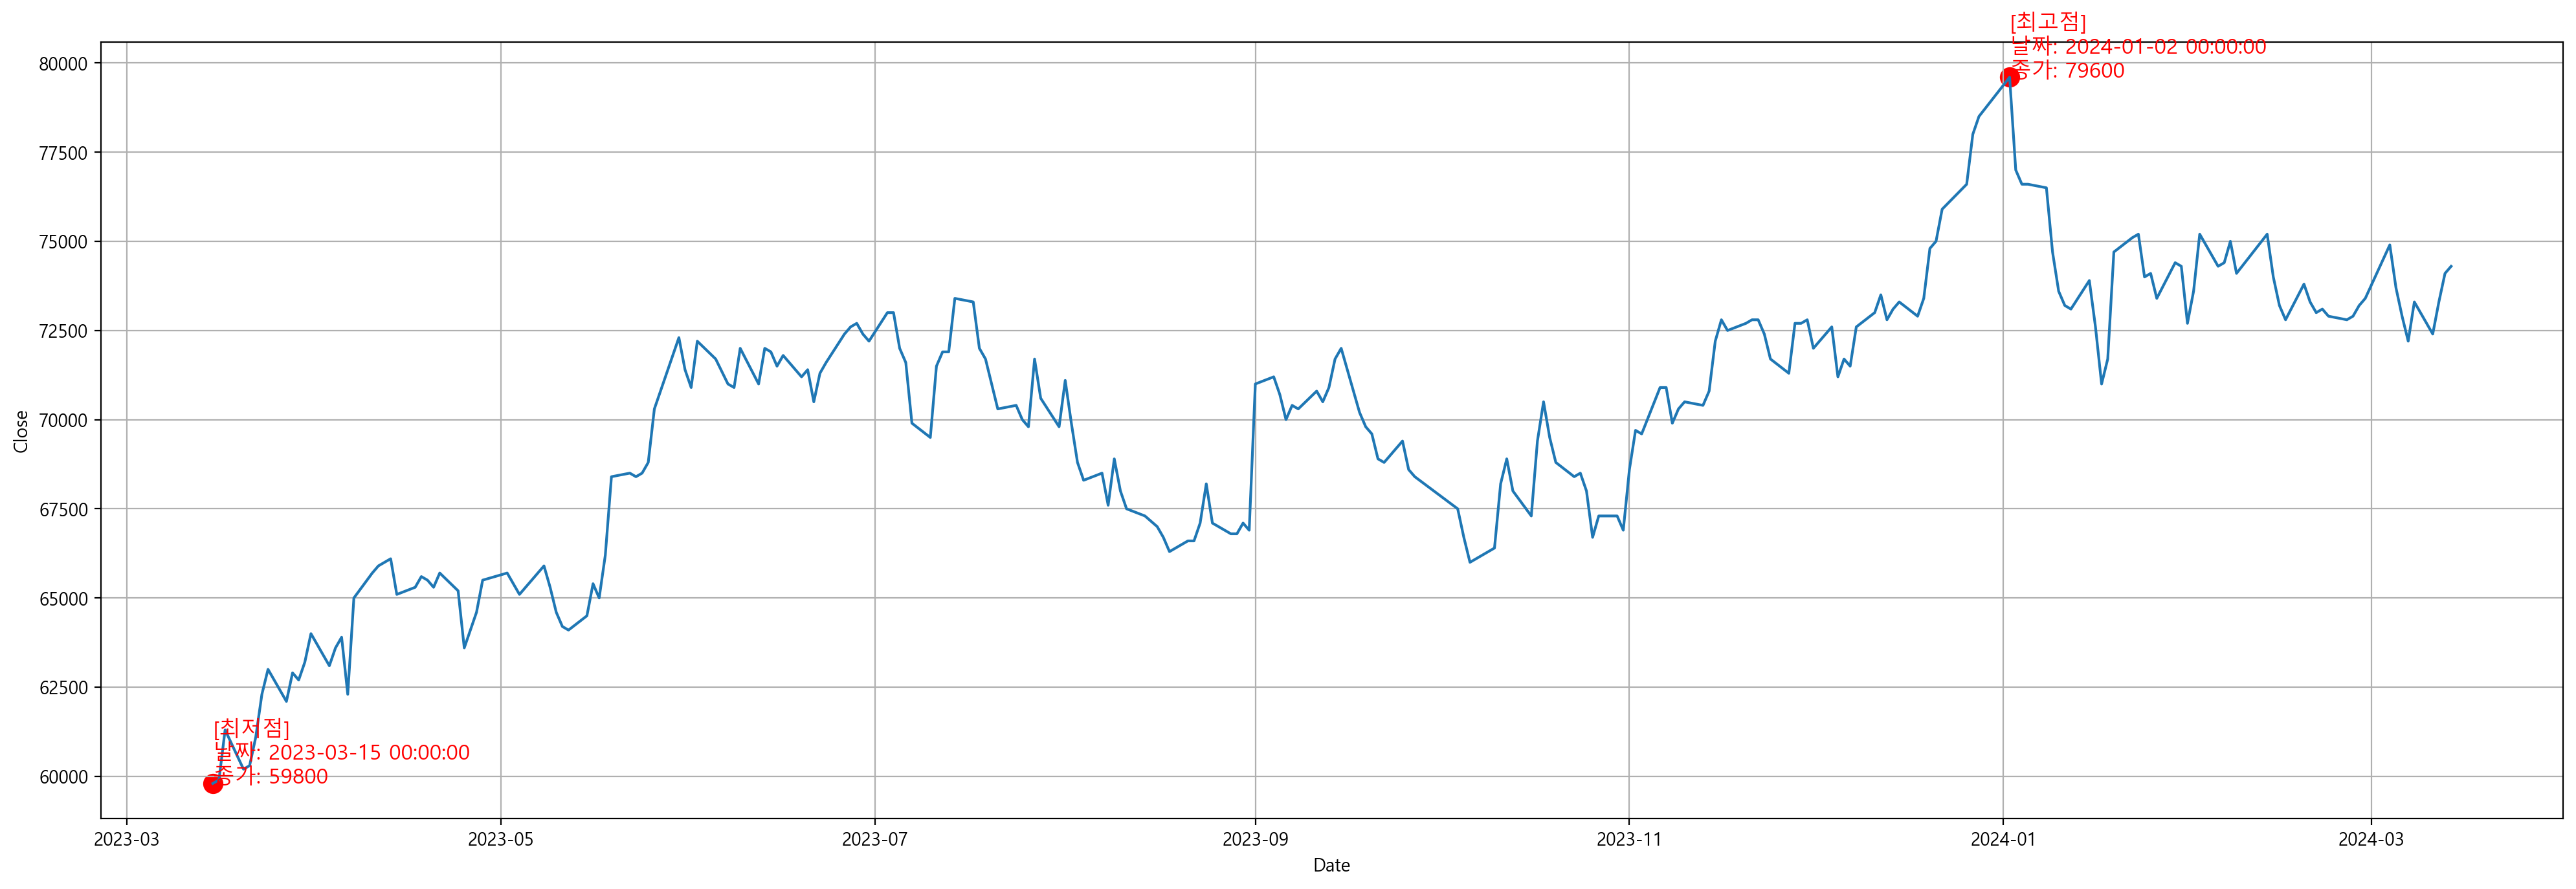

In [8]:
my_lineplot(origin, xname=origin.index, yname='Close', figsize=(20, 7), dpi=200, callback=addon)

## #03. 데이터 전처리

### [1] 기간내 전체 날짜 생성

In [9]:
dates = date_range(start=origin.index.min(), end=origin.index.max(), freq="1D")
dates

DatetimeIndex(['2023-03-15', '2023-03-16', '2023-03-17', '2023-03-18',
               '2023-03-19', '2023-03-20', '2023-03-21', '2023-03-22',
               '2023-03-23', '2023-03-24',
               ...
               '2024-03-05', '2024-03-06', '2024-03-07', '2024-03-08',
               '2024-03-09', '2024-03-10', '2024-03-11', '2024-03-12',
               '2024-03-13', '2024-03-14'],
              dtype='datetime64[ns]', length=366, freq='D')

### [2] 전체 날짜에 대한 데이터 프레임

In [10]:
df1 = DataFrame({
    'Close': 0,
}, index=dates)

df1

,Close
2023-03-15,0
2023-03-16,0
2023-03-17,0
2023-03-18,0
2023-03-19,0
...,...
2024-03-10,0
2024-03-11,0
2024-03-12,0
2024-03-13,0


### [3] 종가만 병합

In [21]:
df1['Close'] = origin['Close']
df1.head(20)

,Close
2023-03-15,59800.0
2023-03-16,59900.0
2023-03-17,61300.0
2023-03-18,NaN
2023-03-19,NaN
2023-03-20,60200.0
2023-03-21,60300.0
2023-03-22,61100.0
2023-03-23,62300.0
2023-03-24,63000.0


### [4] 결측치를 갖는 날짜만 별도로 분리 (=주말)

In [29]:
df2 = df1.fillna(0)
df_tmp = df2[df2['Close'] == 0]
df_tmp['holiday'] = 'holiday'
holiday_df = df_tmp.drop('Close', axis=1)
holiday_df.reset_index(drop=False, inplace=True)
holiday_df.rename(columns={'index': 'ds'}, inplace=True)
holiday_df

,ds,holiday
0,2023-03-18,holiday
1,2023-03-19,holiday
2,2023-03-25,holiday
3,2023-03-26,holiday
4,2023-04-01,holiday
...,...,...
115,2024-03-01,holiday
116,2024-03-02,holiday
117,2024-03-03,holiday
118,2024-03-09,holiday


### [4] 결측치 대체

In [32]:
df2 = df1.fillna(method='ffill') # or backfill
df2.head(20)

,Close
2023-03-15,59800.0
2023-03-16,59900.0
2023-03-17,61300.0
2023-03-18,61300.0
2023-03-19,61300.0
2023-03-20,60200.0
2023-03-21,60300.0
2023-03-22,61100.0
2023-03-23,62300.0
2023-03-24,63000.0


In [33]:
df3 = df2.reset_index()
df3

,index,Close
0,2023-03-15,59800.0
1,2023-03-16,59900.0
2,2023-03-17,61300.0
3,2023-03-18,61300.0
4,2023-03-19,61300.0
...,...,...
361,2024-03-10,73300.0
362,2024-03-11,72400.0
363,2024-03-12,73300.0
364,2024-03-13,74100.0


In [34]:
df4 = df3.rename(columns={"index": "ds", "Close": "y"})
df4

,ds,y
0,2023-03-15,59800.0
1,2023-03-16,59900.0
2,2023-03-17,61300.0
3,2023-03-18,61300.0
4,2023-03-19,61300.0
...,...,...
361,2024-03-10,73300.0
362,2024-03-11,72400.0
363,2024-03-12,73300.0
364,2024-03-13,74100.0


## #04. 시계열 분석 수행

### [1] 기본 설정만으로 진행

In [35]:
params = {
    'changepoint_prior_scale': [0.1, 0.5, 1.0],
    'seasonality_prior_scale': [0.1, 0.5, 1.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'weekly_seasonality': [True, False],
    'daily_seasonality':  [True, False],
    'yearly_seasonality': [True, False],
    'holidays': [holiday_df]
}

In [37]:
def set_hollydays(m):
    m.add_country_holidays(country_name='KR')

+-----+---------------------------+---------------------+-------------------------+--------------------+---------------------------+----------------------+----------------------+---------+
|     |   changepoint_prior_scale | daily_seasonality   | holidays                | seasonality_mode   |   seasonality_prior_scale | weekly_seasonality   | yearly_seasonality   |   score |
|-----+---------------------------+---------------------+-------------------------+--------------------+---------------------------+----------------------+----------------------+---------|
|   0 |                         1 | True                | ds  holiday             | multiplicative     |                       0.5 | True                 | True                 | 5260.07 |
|     |                           |                     | 0   2023-03-18  holiday |                    |                           |                      |                      |         |
|     |                           |                    

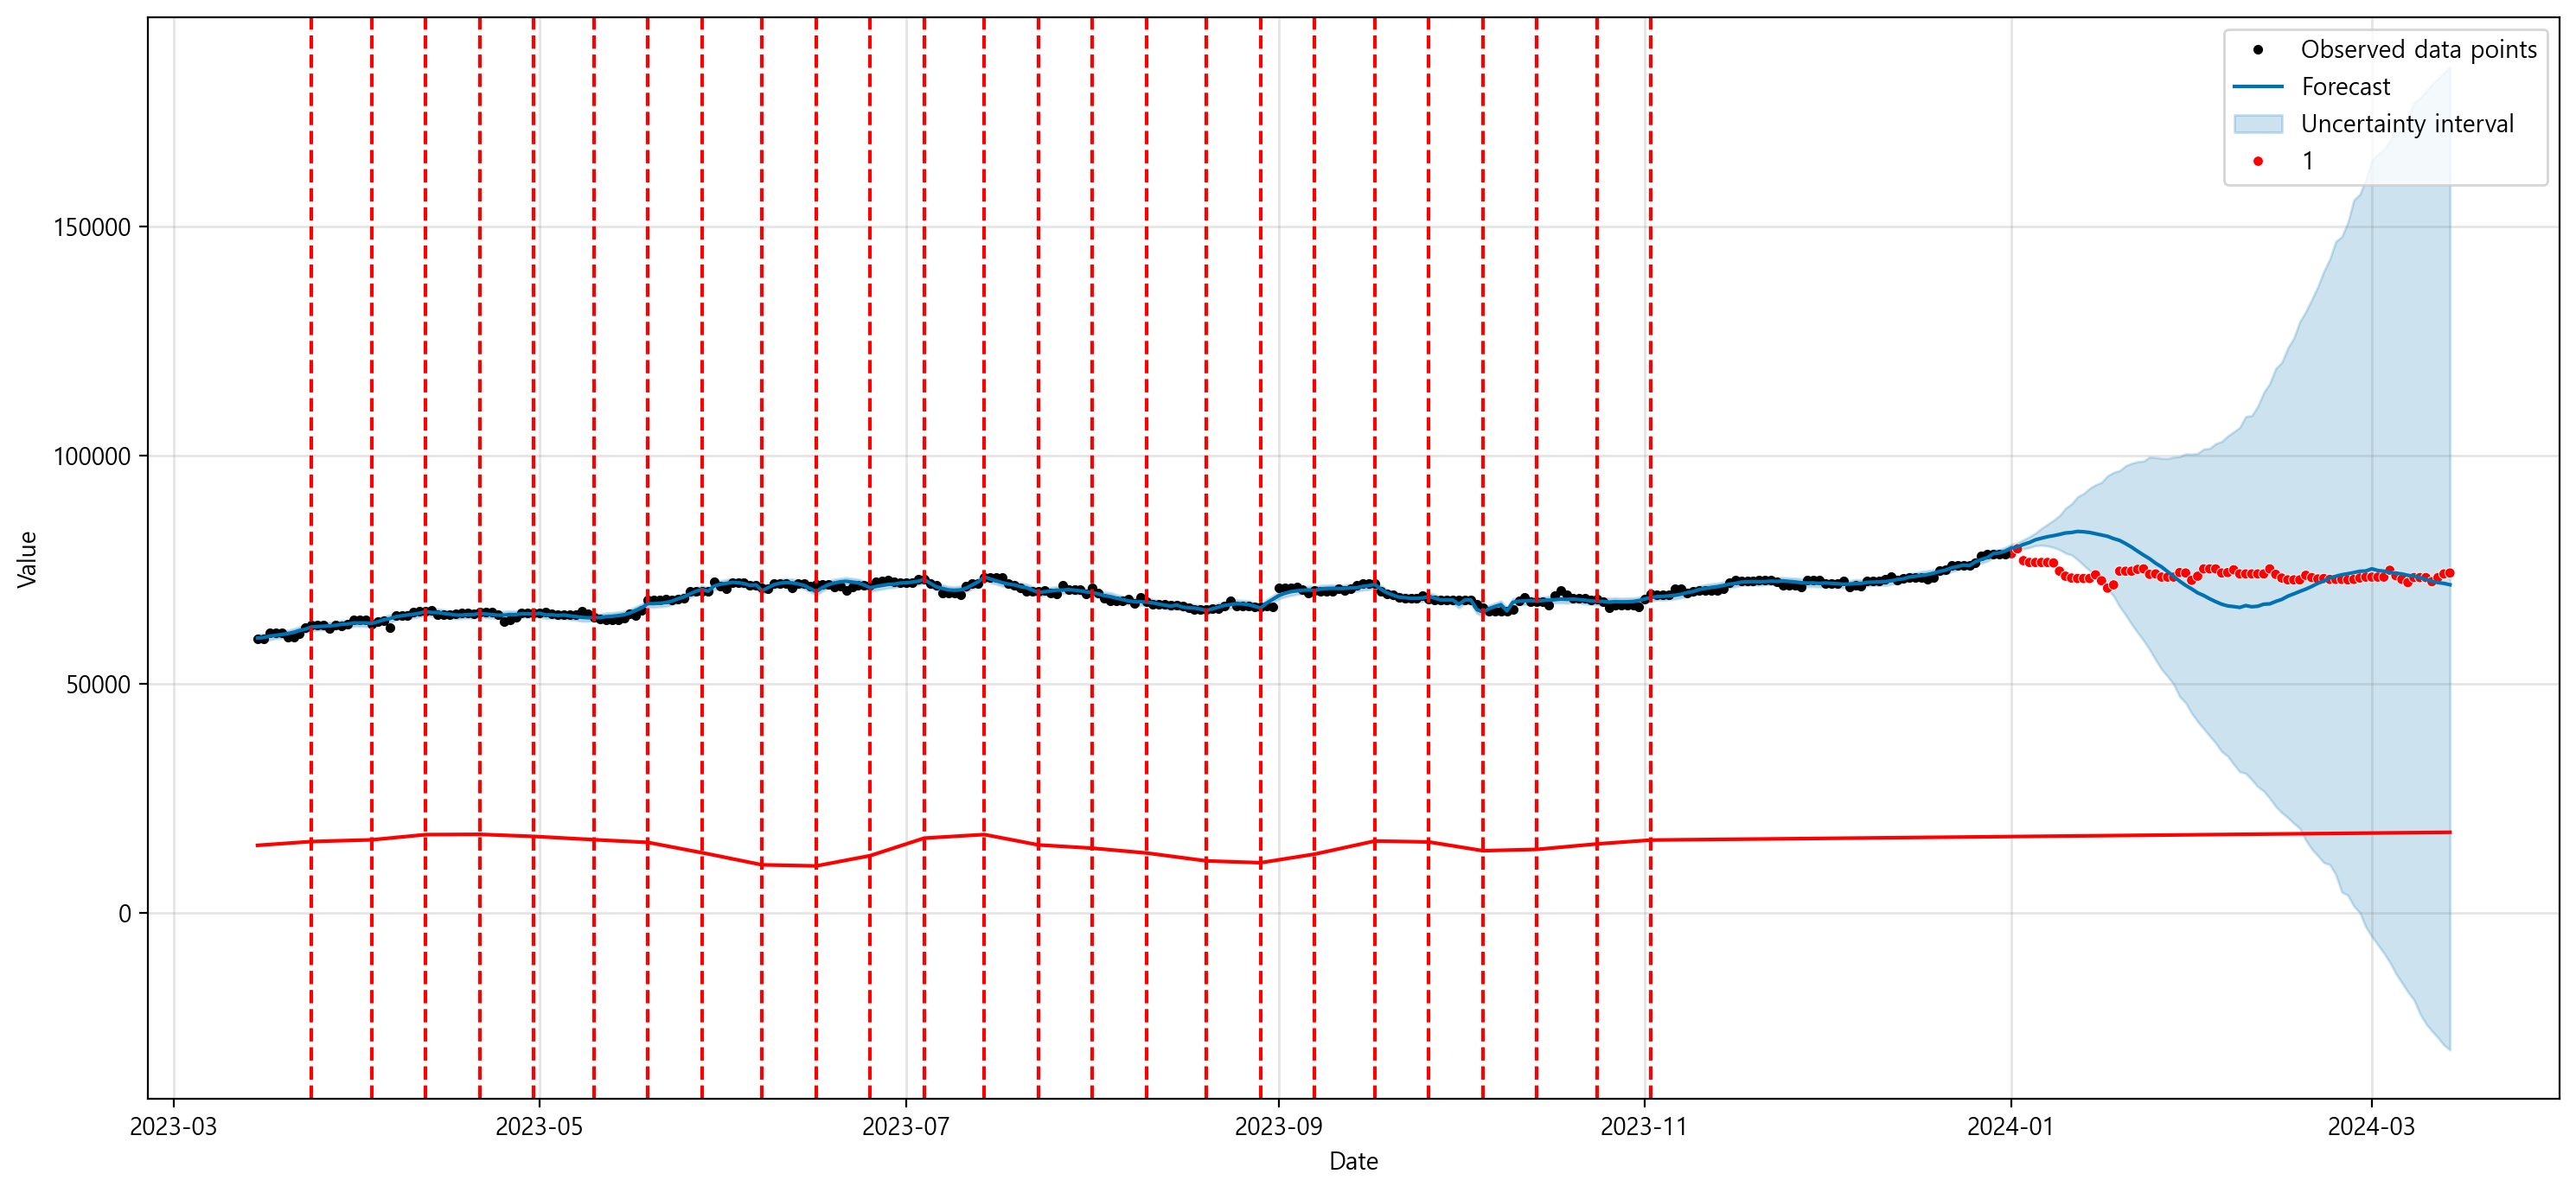

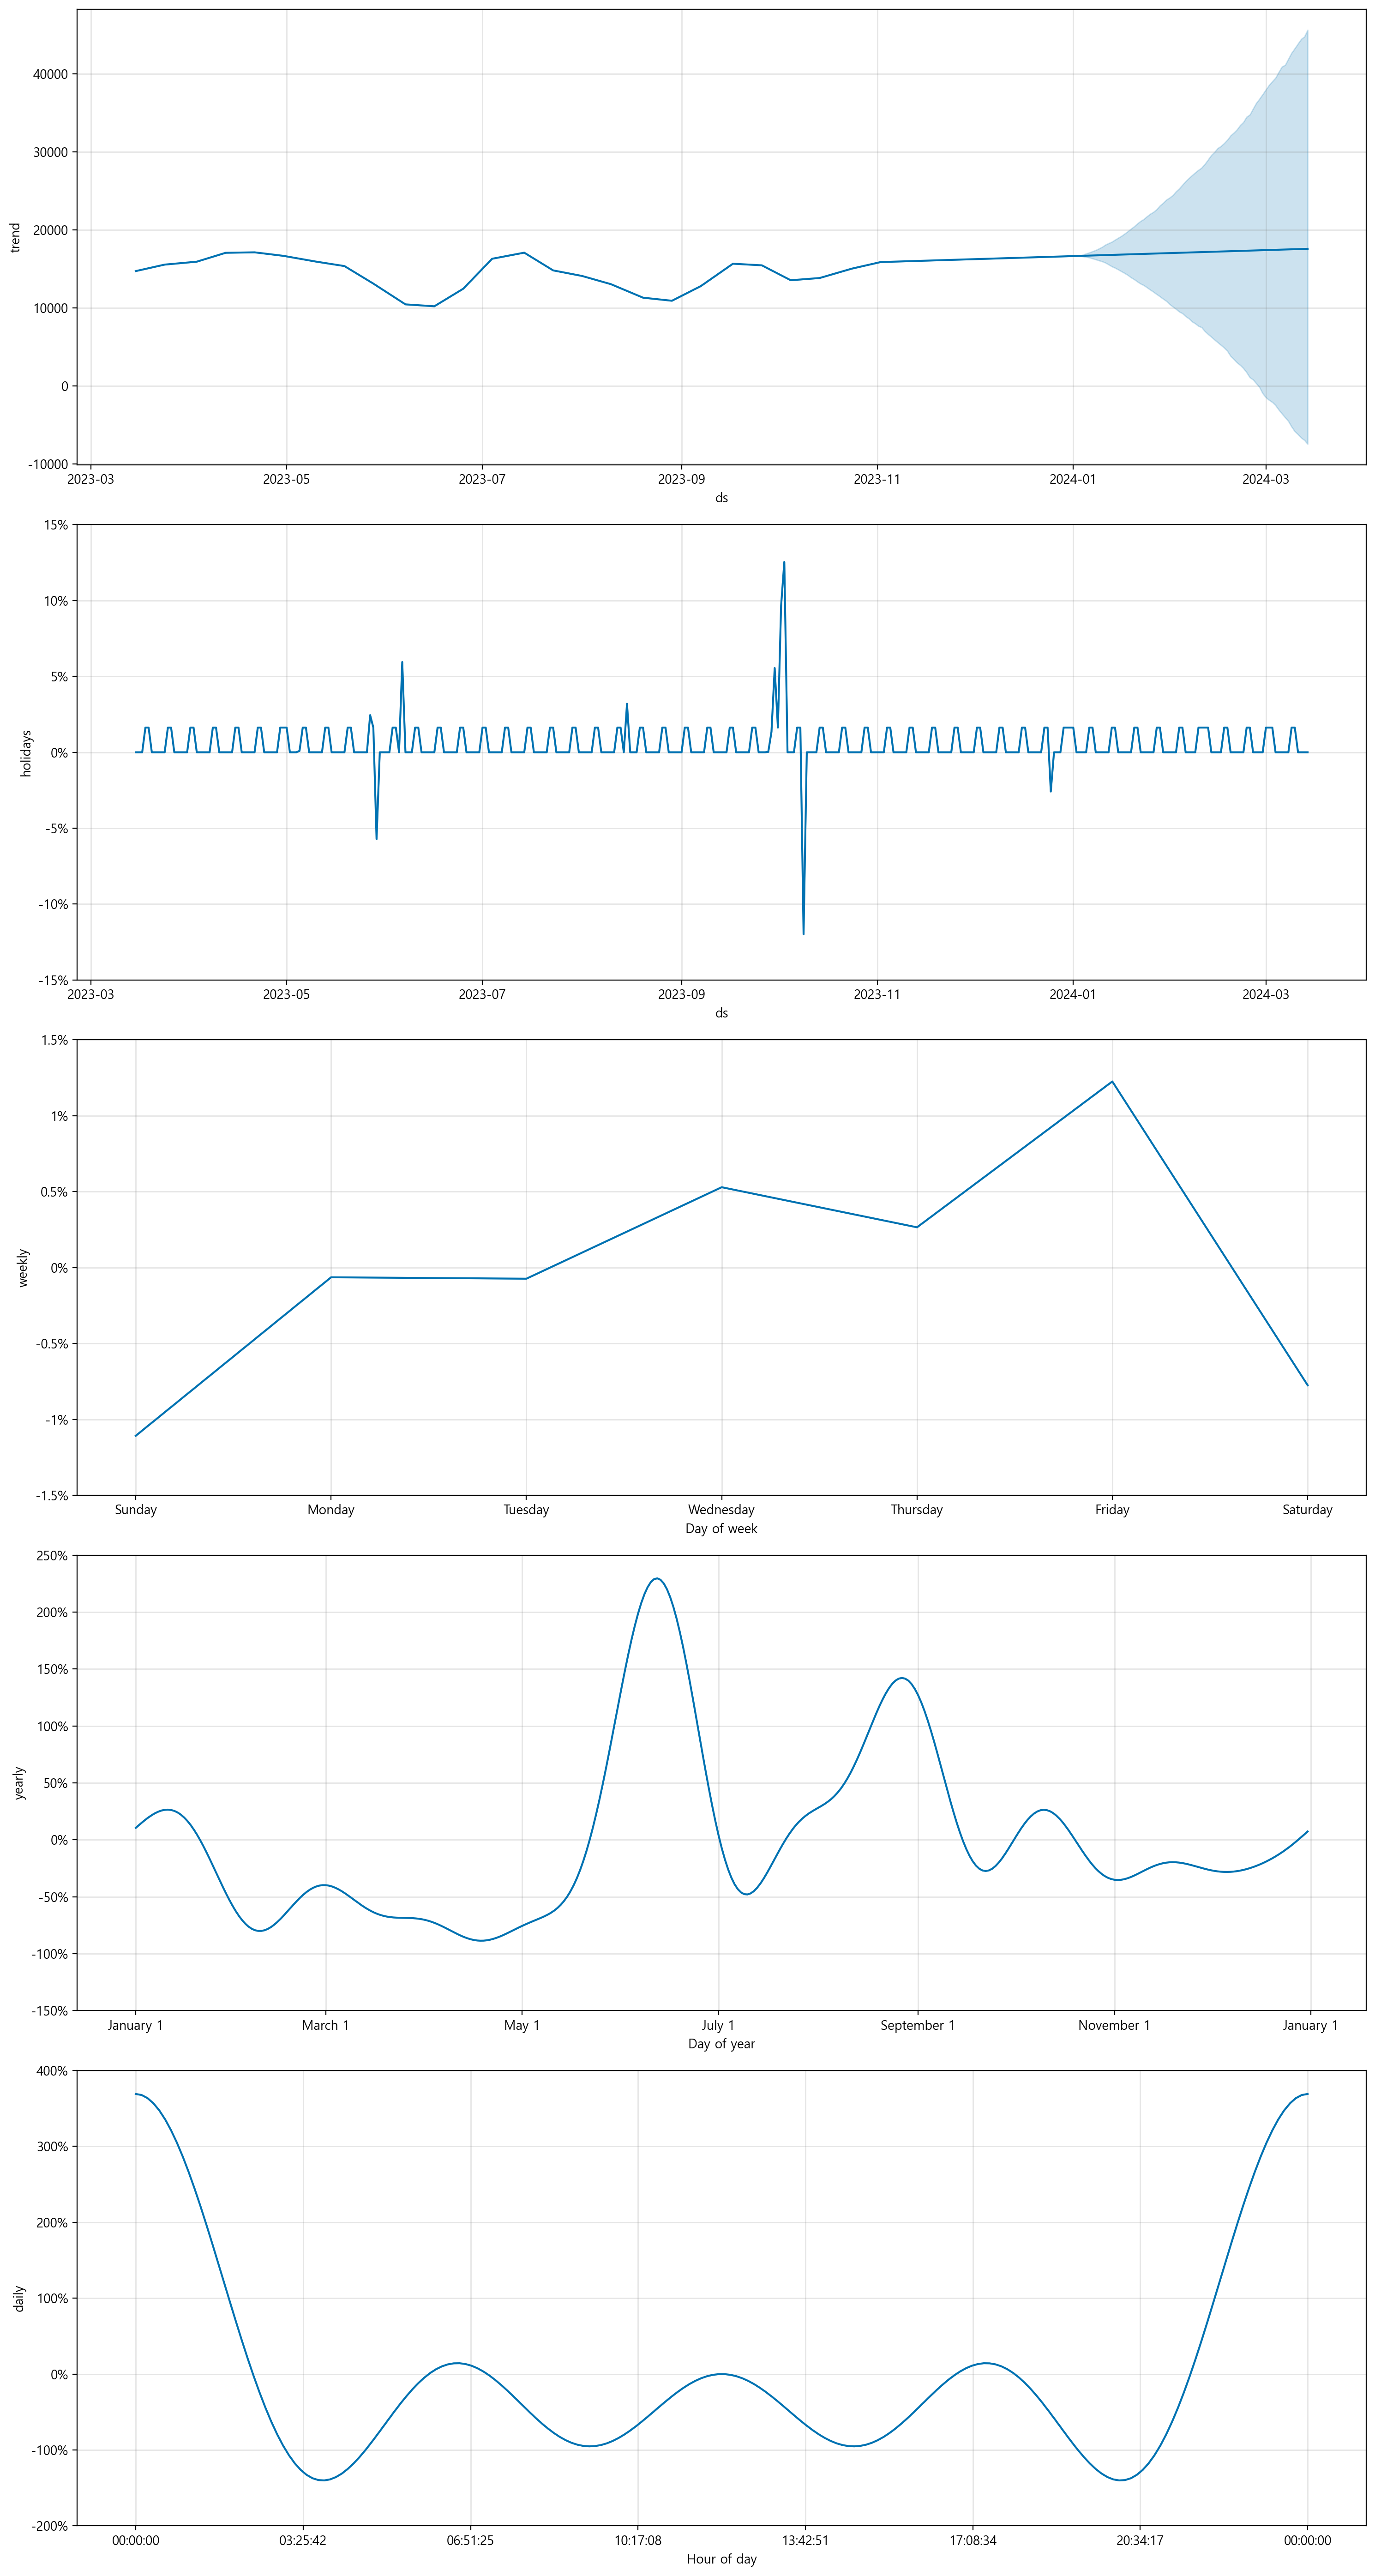

+-------------------+-------------+
|                   |     Prophet |
|-------------------+-------------|
| 평균절대오차(MAE) |     4159.03 |
| 평균제곱오차(MSE) | 2.76683e+07 |
| 평균오차(RMSE)    |     5260.07 |
+-------------------+-------------+


In [38]:
train, test = my_timeseries_split(df4)

model, param, score, forecast, pred = my_prophet(train, test, freq="D", figsize=(15, 7), dpi=200, callback=set_hollydays, **params)